In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
#from torchsummary import summary
import timeit

## Downloading the CIFAR10 Dataset and Visualization

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

Files already downloaded and verified


In [3]:
th.manual_seed(43)

# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> ", "\nTraining data size = ",len(train_ds), "\nValidation data size = ", len(val_ds))

batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Data sizes after random splitting ->  
Training data size =  40000 
Validation data size =  10000


images.shape: torch.Size([128, 3, 32, 32])


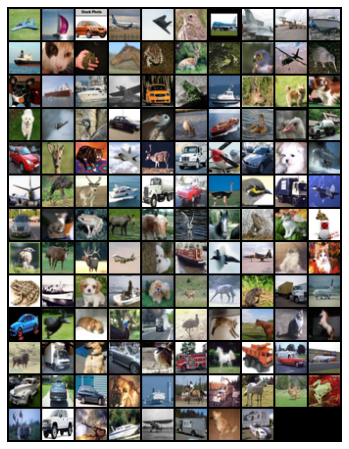

In [5]:
#Visualization of dataset in batches
for index, (images, labels) in enumerate(train_loader):
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    if index == 0:  #number of batches to visualize
      break

## Device Settings

In [6]:
device = th.device('cpu')   #cuda or cpu
print(device)
print(th.cuda.device_count())

cpu
1


## Network Class

In [ ]:
        self.layers = th.nn.ModuleList()
        self.layers.append(th.nn.Linear(num_inputs, num_neurons[0], True))
        self.layers.append(activation[0])
        for i in range(len(num_neurons)-1):
            self.layers.append(th.nn.Linear(num_neurons[i], num_neurons[i+1], True))
            self.layers.append(activation[i+1])
        self.layers.append(th.nn.Linear(num_neurons[-1], num_classes, True))

In [ ]:
class ResBlock(th.nn.Module):
    def __init__(self, in_features):
        super(ResBlock, self).__init__()
        self.in_features = in_features
        
        self.conv = nn.Conv2d(self.in_features, self.in_features, 3)
        
    
    def forward(self, x):
        H = nn.relu(self.conv(x))
        H = self.conv(x)
        x = nn.relu(H + x)
        return x
        
        
        
class ResNet(th.nn.Module):
    def __init__(self, in_channels, num_classes, num_blocks):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_blocks = num_blocks

        self.activation = nn.ReLU()
        self.dense = nn.Linear()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(3, in_channels[0], 7, stride=3, padding=1))
        self.layers.append(activation)
        for i in range(len(in_channels)-1):
            ResBlock(in_channels[i])
            self.layers.append(nn.Conv2d(in_channels[i], in_channels[i+1], 3, padding=1))
            self.layers.append(activation)
        self.layers.append(ResBlock(in_channels[-1]))
        self.layers.append(nn.AvgPool2d(2))
        
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, !!)
        x = nn.Linear(!! , self.num_classes)
        return x


In [ ]:
model = ResNet(in_channels=[32,64,128], num_classes=10, num_blocks=3).to(device=device)
print(model)

## Train Function and Evaluate Function

In [ ]:
def train(model, dataloader, optimizer, lossFunction, device=th.device('cpu'), debug=False):
    loss_hist = np.array([])

    for index, (images, labels) in enumerate(dataloader):
        #zero the parameter gradients
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        prediction = model(images)
        loss = lossFunction(prediction, labels)
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()

        if debug: 
            with th.no_grad():
                if index % 100 == 0:
                    print("{}/{} Loss:{:.6f}".format(index, len(dataloader), loss.item()))

    return loss_hist

def evaluate(model, dataloader, lossFunction, device=th.device('cuda')):   

    total_loss = 0
    total_acc = 0.0

    for index, (images, labels) in enumerate(dataloader):

        images = images.to(device)
        labels = labels.to(device)
        
        prediction = model(images)
        loss = lossFunction(prediction, labels)
        total_loss += loss.item()

        pred_label = th.argmax(prediction, dim=1)  #hardmax
        acc = ((pred_label==labels).sum().item() / len(labels))
        total_acc += acc

    return total_acc/len(dataloader), total_loss/len(dataloader)

## Optimizer and Loss Function

In [ ]:
optimizer = th.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))

lossFunction = th.nn.CrossEntropyLoss()

## Main Module

In [ ]:
def main():

    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])

    epoch = 25

    start_time = timeit.default_timer()

    for i in range(epoch):
          #training
          loss = train(model, train_loader, optimizer, lossFunction, device=device, debug=False)

          #evaluation
          avg_acc, avg_loss = evaluate(model, val_loader, lossFunction, device=device)

          # loss and accuracy histories are kept
          training_loss_hist = np.append(training_loss_hist, loss)
          valid_loss_hist = np.append(valid_loss_hist, avg_loss)
          valid_acc_hist = np.append(valid_acc_hist, avg_acc)

          print("epoch {} evaluation loss: {} evaluation acc: {}".format(i, avg_loss, avg_acc) )

    stop_time = timeit.default_timer()

    print("Time: ", stop_time-start_time)

In [ ]:
fig, (axs1, axs2) = plt.subplots(2)
axs1.plot(valid_loss_hist, "tab:purple", label="Validation loss")
axs1.legend()
axs2.plot(valid_acc_hist, "tab:pink", label="Validation acc")
axs2.legend()

In [ ]:
test_acc, test_loss = evaluate(model, val_loader, lossFunction, device=device)
print("test accuracy: {} , test loss: {}".format(test_acc, test_loss))

## Model Saving

In [ ]:
th.save(model.state_dict(), "Resnet_model")

In [13]:
class A:
    def __init__(self, inputt):
        self.inputt = inputt
        print("init")
        
        
    def hi(self):
        print("naber ", self.inputt)
        
a = A("Cansu")
a.hi()

        

init
naber  Cansu
